<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Markov Chain Monte Carlo (MCMC) Simulations

_Authors: Dan Wilhelm (LA)_ 

---

### Learning Objectives
- Explain when you would use the beta and binomial distributions
- Describe the concept of "conjugacy" and "conjugate priors" in Bayesian statistics
- Explain when we might use MCMC
- Understand how the Metropolis-Hasting algorithm works at a high level
- List ways of tuning MCMC


### Outline
1. [Premise](#premise)
2. [Review Q&A](#qa)
3. [Prior, Likelihood, Posterior Example](#plp)
4. [MCMC](#mcmc)
5. [Metropolis-Hastings Implementation](#mhi)
6. [Match a Beta Distribution Using Moment Matching](#match)
7. [Confidence Intervals](#ci)
8. [Other Considerations](#other)

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from scipy.stats import beta, poisson, norm

def plot_distr(distr, xlim=[0., 1.], xlabel='p', ax=None):
    
    if not ax:
        fig, ax = plt.subplots(figsize=(8,6));
    
    # Generate 100 x values in the appropriate
    # range to use for plotting:
    x = np.linspace(xlim[0], xlim[1], 100);
    
    # Generate line plot.
    ax.plot(x, distr.pdf(x),
            'b', lw=2);

    # Plot customization:
    ax.set_ylabel('Density', fontsize=18);
    ax.set_xlim(xlim);
    ax.set_yticks([]);
    ax.set_xlabel(fr'Values of {xlabel}', fontsize=18);
    ax.set_title(fr'{distr.dist.name.capitalize()} Distribution', fontsize=24);

<a id="premise"></a>
# Premise

In the last lesson, we predicted who might win an election. Each voter votes for one of two candidates by making a biased coin flip. 

Today, we will begin by reviewing the procedure step-by-step. 

Instead of the presidential campaign, however, let's do an analogous situation: 

- We have a new COVID vaccine which we are optimistic about.
- We just got the result of a clinical trial. 
- How will the new clinical trial affect our belief of the drug's efficacy?

We are trying to predict the probability the vaccine will successfully work on a patient.

---
# Review

1. First, we choose a **prior** that reflects our belief of the vaccine's probability of working. (beta distribution)
2. Second, we model the **likelihood** of success as similar to a sequence of coin flips. (Binomial distribution)
3. Finally, we compute our updated belief of the vaccine's probability of working, the **posterior**.
> Knowing the prior and likelihood, we can always compute the posterior using Bayes' Rule:<br>
> $$\textbf{posterior} \propto \textbf{likelihood} * \textbf{prior}$$

In this case, we got lucky -- there is a very simple way of computing the posterior using a **conjugate prior**:

- beta prior + binomial likelihood = beta posterior.
    - $\alpha_{posterior} = k + \alpha_{prior}$
    - $\beta_{posterior} = n - k + \beta_{prior}$

The result is a probability distribution, representing our updated belief about who will win the election.

---

<a id="qa"></a>
# Q & A

This is likely still confusing, so let's answer a few questions you may have about it.

### 1. What is a prior?

A **prior** is a probability distribution of our belief of some value we are measuring, "prior to" being shown evidence. In this example, we have a belief about the efficacy of our vaccine.

> The area under a probability distribution is always 1. So, continuous distributions are often shown without y-axis tick marks.

**Example 1.** Suppose we are predicting the number of fish caught per day at my grandfather's lake. I take a quick guess that I can catch five fish each day. I also note that the number of fish I catch is discrete, not continuous. So, I could choose for the prior a Poisson distribution with mean 5.

**Example 2.** Suppose I am doing a linear regression, where I know my data is linear. I am trying to estimate the measurement error. I know the error is normally distributed, but I don't know the standard deviation. Based on my prior knowledge of my ruler's accuracy, I estimate the standard deviation as 1 cm. So, the prior will be a normal distribution with standard deviation of 1 cm.

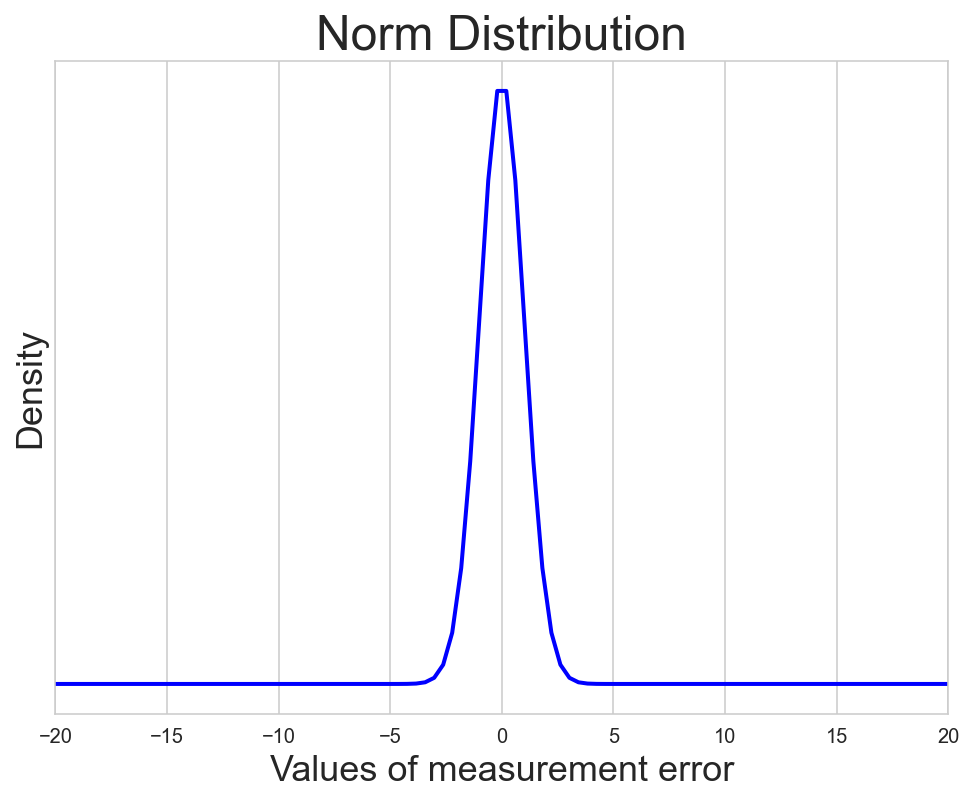

In [4]:
# Prior of measurement error with standard deviation = 1 cm.
plot_distr(norm(0, 1), xlim=[-20, 20], xlabel='measurement error')

---
### 2. Why do we choose a "beta distribution" for our prior?

We first thought about what we are trying to solve for -- in this case, the probability that our drug cures a patient of COVID.

We don't know the exact probability, so we must take a guess. We're pretty sure it won't be 100% effective. Based on our knowledge of similar drugs, we'll (very optimistically) guess that 60% of patients will be cured by it -- but we're not very sure.

So, our prior will be a distribution over probability values (i.e. from 0 to 1), with the peak occuring at around a 0.6 probability. This distribution of probability values is a **beta distribution**!

> In other words, a beta distribution is a probability distribution of probabilities!

**Example:**

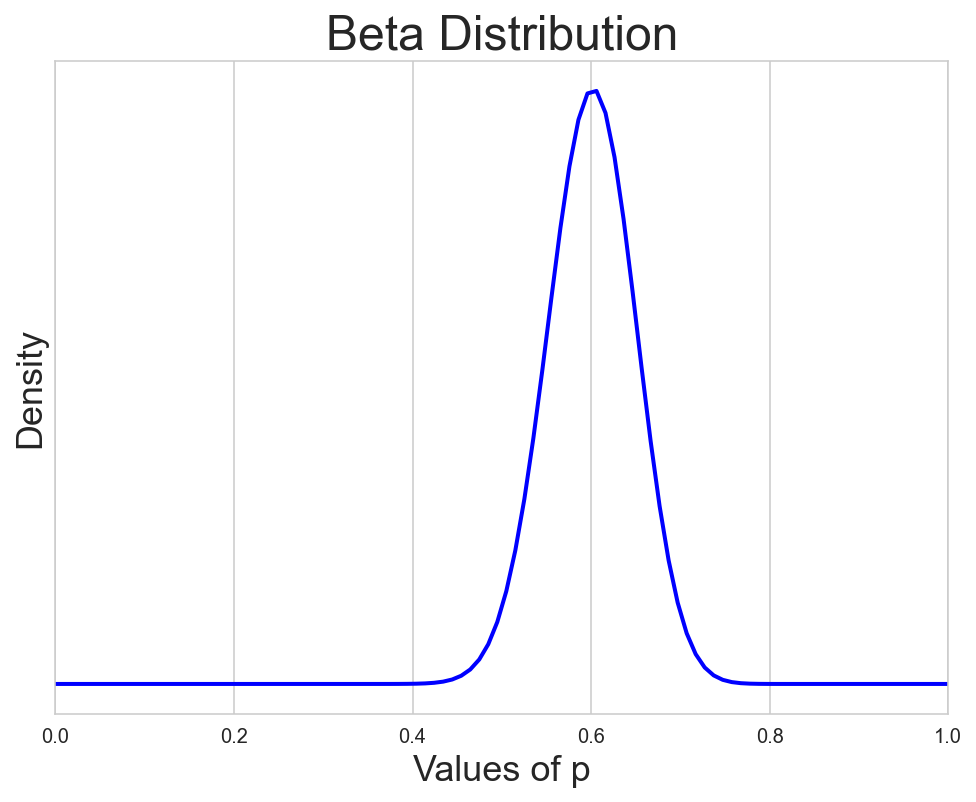

In [5]:
# Beta prior with mean of 0.6
plot_distr(beta(60,40))  # Note the mean is at: alpha / (alpha + beta).

**Question:** How would you explain this prior to someone in a simple way?

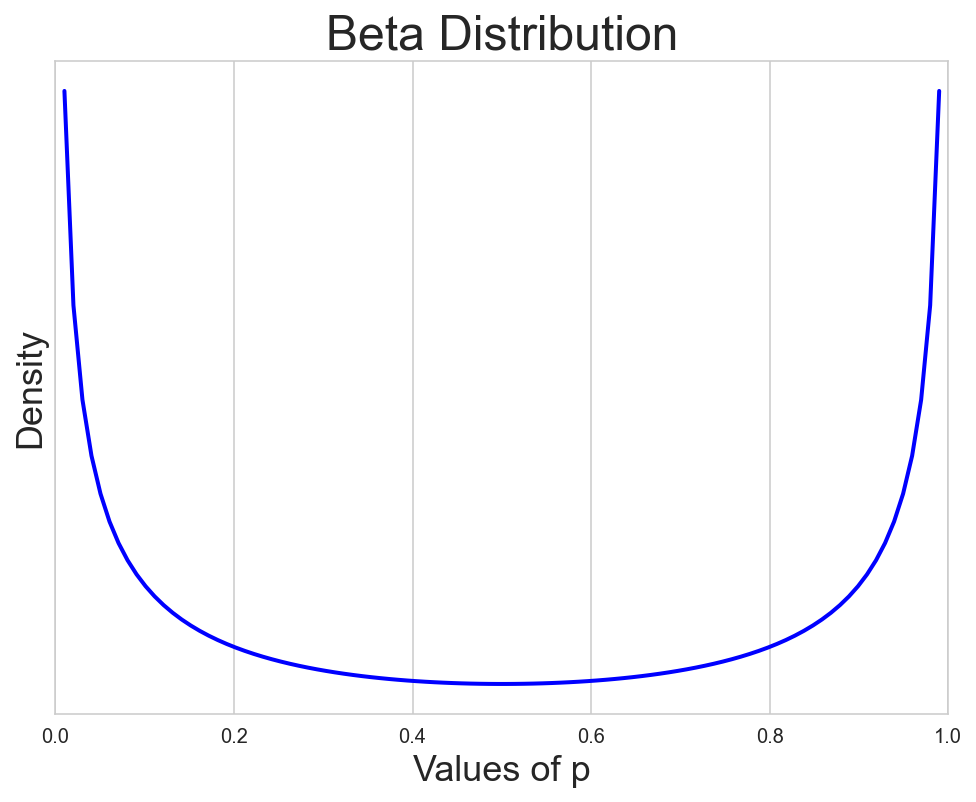

In [6]:
plot_distr(beta(0.5,0.5))

---
### 3. How do we decide on the parameters $\alpha$ and $\beta$?

Keep in mind that the prior is just a _guess_ based on our intuition! There is no right or wrong answer -- as long as you have a solid explanation for _why_ they were chosen.

One common way of estimating them is called _moment matching_, where we start with a mean and standard deviation, then solve for $\alpha$ and $\beta$.

In this case, let's make sure our mean is correct ($mean = \frac{\alpha}{\alpha + \beta}$), then we'll adjust it until it looks similar to what we might expect.

**Question:** Which of the below three graphs might be the best choice for the prior, given that we believe it is most likely to cure 60% of patients, but we're not very sure?

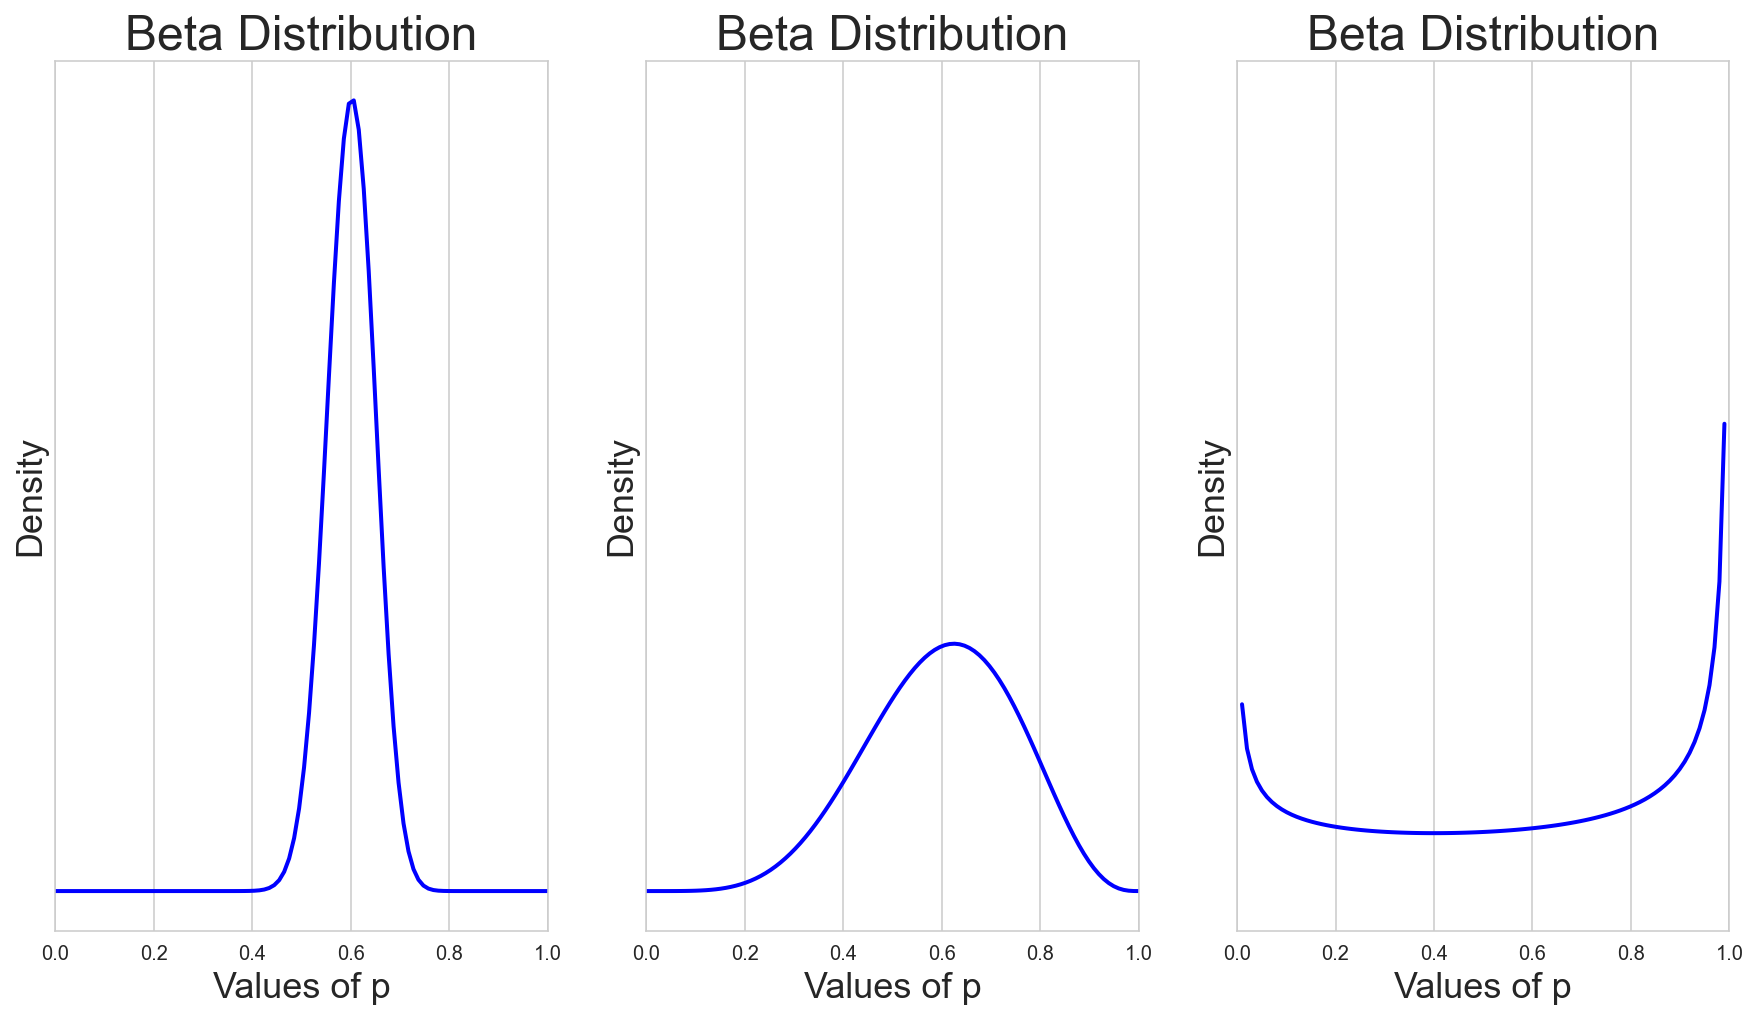

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(15,8));

# Beta prior with mean of 0.6 = alpha / (alpha + beta).
plot_distr(beta(60,40), ax=ax1);    # Left
plot_distr(beta(6,4), ax=ax2);      # Middle
plot_distr(beta(0.6,0.4), ax=ax3);  # Right

---
### 4. Why did we decide on a Binomial distribution for the likelihood?

We decide to treat each recipient of the vaccine as a biased coin flip. With probability $p$, the vaccine works; with probability $1-p$, it does not work. When we repeat the vaccine trial over many people, the binomial distribution describes the resulting distribution of successes.

![](images/binomial.png)
[Source](https://en.wikipedia.org/wiki/Binomial_distribution)

The Binomial distribution is discrete and has two parameters -- $n$ the total number of independent trials, and $p$ the probability of success (for each trial). Its pmf describes the probability of exactly $k$ successes, from $0$ to $n$.

**Example.** Suppose we have $n=100$ vaccine trials, each with a probabilty $p=0.6$ of success. We wonder after these 100 trials, what will the probability be of any particular number of successes? Let's build a histogram by sampling from the distribution.

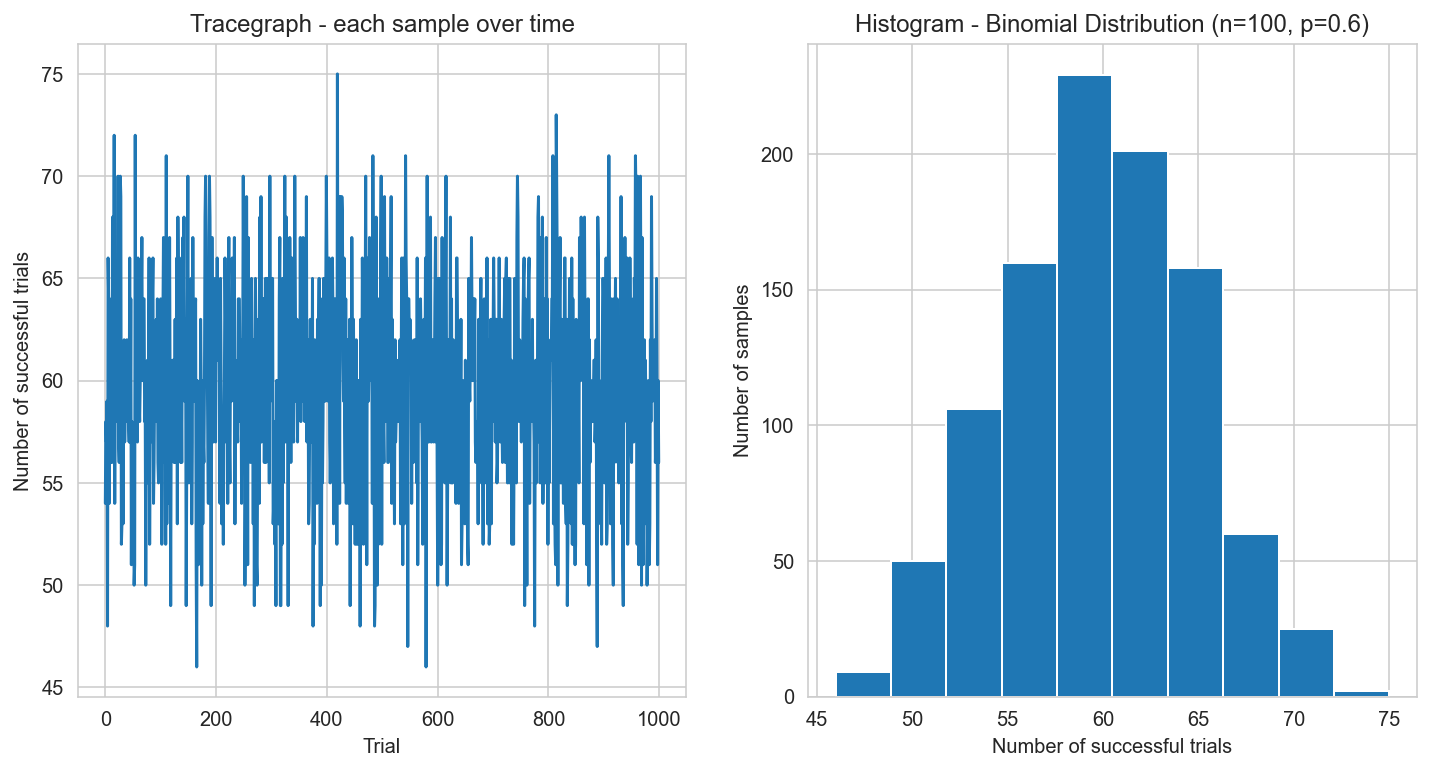

In [8]:
fig, (ax_trace, ax_hist) = plt.subplots(1,2, figsize=(12,6))

samples = stats.binom(100, 0.6).rvs(1000)   # 1000 samples

# Plotted one after each other (a tracegraph)
ax_trace.plot(np.arange(1000), samples);
ax_trace.set_title('Tracegraph - each sample over time')
ax_trace.set_xlabel('Trial')
ax_trace.set_ylabel('Number of successful trials')

#
ax_hist.hist(samples);
ax_hist.set_title('Histogram - Binomial Distribution (n=100, p=0.6)');
ax_hist.set_xlabel('Number of successful trials');
ax_hist.set_ylabel('Number of samples');

We will be sampling a lot today with MCMC!

**Question.** Why might we use a binomial distribution to model election day, where candidates choose between Candidate A and Candidate B?

---
### 5. What is a conjugate?

In certain prior/likelihood pairs, the posterior can be algebraically derived. If this is the case, then the prior is the **conjugate**.

In this case, we can use the following conjugate shortcut:
- Beta prior + Binomial likelihood = Beta posterior.
    - $\alpha_{posterior} = k + \alpha_{prior}$
    - $\beta_{posterior} = n - k + \beta_{prior}$

There are other shortcuts too:
- Normal prior + Normal likelihood = Normal posterior. (You are familiar with this already!)
- Gamma prior + Poisson likelihood = Gamma posterior.


Of course, most distributions do not conveniently result in the posterior. Hence, there is a need for MCMC simulation.

---

<a id="plp"></a>
## Prior, Likelihood, Posterior Example

Let's look at the prior, likelihood, and posterior distributions from last lesson:

In [9]:
# Sample data
num_success = 10
num_vaccines = 100

# Create list of percentages for plotting x-axes
percentages_for_plotting_x_axes = np.linspace(0, 1, 1001)

# Create our uninformed prior
alpha_prior = 9
beta_prior = 3
prior_distr = stats.beta(alpha_prior, beta_prior)

# Create alpha and beta posteriors using the conjugate shortcut
alpha_posterior = alpha_prior + num_success
beta_posterior = num_vaccines - num_success + beta_prior
posterior_distr = stats.beta(alpha_posterior, beta_posterior)

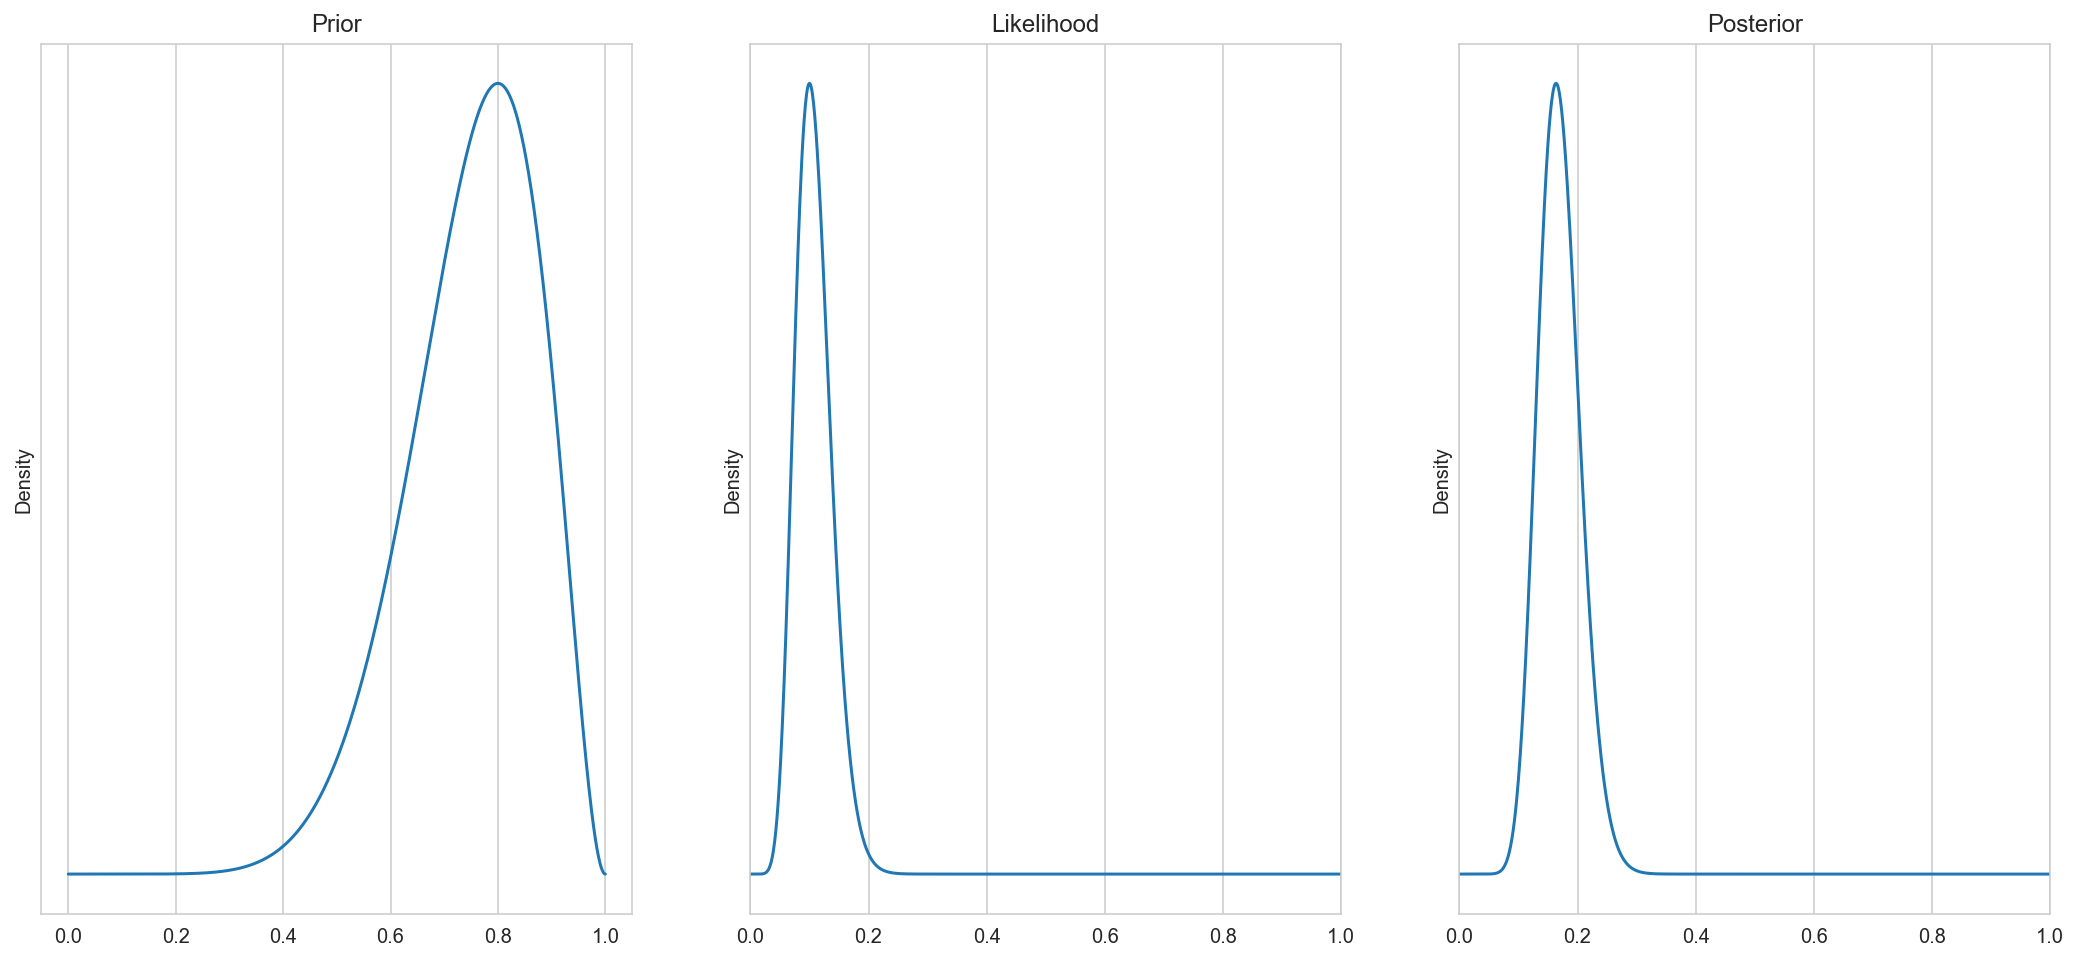

In [11]:
#########
# PLOT

fig, (ax_prior, ax_likelihood, ax_posterior) = plt.subplots(1, 3, figsize=(18,8))

# Plot prior
ax_prior.plot(percentages_for_plotting_x_axes, prior_distr.pdf(percentages_for_plotting_x_axes))
ax_prior.set_ylabel('Density')
ax_prior.set_yticks([])
ax_prior.set_title('Prior')

# Plot likelihood
likelihoods = [stats.binom(num_vaccines, p).pmf(num_success) for p in percentages_for_plotting_x_axes]
ax_likelihood.plot(percentages_for_plotting_x_axes, likelihoods)
ax_likelihood.set_xlim([0, 1])
ax_likelihood.set_ylabel('Density')
ax_likelihood.set_yticks([])
ax_likelihood.set_title('Likelihood')

# Plot posterior
ax_posterior.plot(percentages_for_plotting_x_axes, posterior_distr.pdf(percentages_for_plotting_x_axes))
ax_posterior.set_xlim([0, 1])
ax_posterior.set_ylabel('Density')
ax_posterior.set_yticks([])
ax_posterior.set_title('Posterior');

You can think of the likelihood as pulling and pushing on the prior!

<a id="mcmc"></a>
## Markov Chain Monte Carlo (MCMC) Simulation
---

Typically, the prior and likelihood distributions do not generate a convenient posterior!

In fact, computing the posterior mathematically is nearly always not possible due to the complexity.

MCMC allows us to compute the posterior via simulation.

---
### 1. What is Monte Carlo?

![](images/casino-monte-carlo.jpg)
[Source](https://en.wikipedia.org/wiki/Monte_Carlo_Casino)

Monte Carlo is named after the Monte Carlo Casino in Monaco.

> **Monte Carlo** refers to any algorithm that uses repeated random sampling.

**Example.** The canonical Monte Carlo example estimates the value of $\pi$ by generating random numbers between 0 and 1.

**Solution.** To do this, we choose random points in the square [0, 1]. Then, we count how many of the points lie within the quarter-circle with radius 1 (of course, $A = \pi r^2/4$). If we then divide the two areas:

$$
\frac{\texttt{# points in circle}}{\texttt{# points in square}} \approx \frac{A(circle)}{A(square)} = \frac{\pi r^2/4}{1 \times 1} = \frac{\pi}{4}.
$$

In [12]:
# Canonical Monte Carlo algorithm - uses repeated random sampling to estimate pi

N = 1_000_000

pts = np.random.random((N,2))   # Generate N pairs of random numbers between 0 and 1

# Compute the fraction of points inside the circle with radius 1, i.e. x^2 + y^2 <= 1.
#     Note this estimates A(circle) / A(square) = pi/4.


3.14212

---
### 2. What is a Markov Chain?

![](images/markov-chain.png)
[Source](https://en.wikipedia.org/wiki/Markov_chain)

A Markov chain is a random process where the probability of each next state is dependent only on the current state.

Markov chains have two important properties:
1. **The Markov property.** The probability of transitioning to a given state is _only_ dependent on the current state and nothing else.
2. **Stationarity.** Given sufficient time, the probability of being in a given state is constant.

---
### 3. What is an MCMC Simulation?

MCMC stands for Markov Chain Monte Carlo.

> MCMC is used for sampling from complex distributions that we cannot directly sample from. 

A good example of this is a posterior distribution! Most prior+likelihood combinations do not result in an easy posterior distribution. So, we need a method such as MCMC to sample from it.

---
### 4. What (or who) is Metropolis?

The Metropolis algorithm often is considered one of the [top 10 most influential algorithms](https://www.computer.org/csdl/magazine/cs/2000/01/c1022/13rRUxBJhBm). 

It was created under the supervision of Nick Metropolis in the 1950s for the use in solving science problems at Los Alamos National Laboratory.

As you'll see in the next lesson, once an algorithm such as MCMC is implemented, it is easy to solve problems that involve any prior+likelihood combination. Nowadays, there are better algorithms than Metropolis -- but they are more difficult to understand.

---
### 5. How does the Metropolis Algorithm work?

The algorithm is iterative. 

1. Choose any starting value from the posterior distribution (with a non-zero density) -- here, 0.5. 
2. Choose a second "proposed" value from the posterior distribution.
    - Typically, we'd sample from a Normal distribution about the first value.
    - However, we will use a beta distribution, since a Normal can have values outside of 0 and 1 (requires Metropolis-Hastings).
3. Using Bayes' Rule, compute the posterior of each using the prior and likelihood distributions.
4. Accept the new value if it is more likely; otherwise, accept it proportionally based on its probability.
    - Accept the new value with probability min(1, posterior_proposed / posterior_curr).
5. Repeat Steps 2-5.

---
### 6. What is Metropolis-Hastings?

The Metropolis algorithm requires choosing a new sampled value symmetrically about the last. However, this is not always possible in our case since probabilities are only between 0 and 1. Metropolis-Hastings incorporates a correction factor that accommodates for choosing new sampled values in a non-symmetrical way.

W. K. Hastings. "Monte Carlo sampling methods using Markov chains and their applications." Biometrika 57.1 (1970): 97-109. [JSTOR](https://www.jstor.org/stable/2334940)


---
### 7. Where does a Markov Chain come in?

Each trial either accepts or rejects the current posterior value. So, each value is like one stage in a Markov chain that stays in the stage with some probability $p$ or transitions with probability $1-p$. The most probable posterior values will have larger "stay" probabilities, and so they will be sampled more frequently.

<a id="mhi"></a>
## Metropolis-Hastings Implementation

In [29]:
NUM_TRIALS = 50000   # number of trials
TUNING_BETA = 4.     # adjust to affect acceptance rate

prior_distr = stats.beta(alpha_prior, beta_prior)                           # Prior is a Beta distribution
likelihood_pmf = lambda p: stats.binom(num_vaccines, p).pmf(num_success)    # For a given p, compute likelihood

def bayes_posterior(p):
    """
    Using Bayes' Rule, compute the posterior density
        P(p | data) ∝  P(data | p) * P(p)
        posterior   ∝   likelihood * prior
    """
    prior = prior_distr.pdf(p)        # Probability of p
    likelihood = likelihood_pmf(p)    # Likelihood given p
    
    return likelihood * prior         # P(data & p)


# Default beta is arbitrary
def get_beta(u, b=TUNING_BETA):
    """Returns a beta distr with mean `u` and given beta `b`."""
    alpha = 0.    # rearranged:  u = alpha / (alpha + beta)
    
    return beta(alpha, b)

In [30]:
###########################################


posterior = []       # Will contain the posterior probability distribution
p_curr = 0.5         # Choose an initial probability - can be anything with non-zero density
acceptance_rate = 0.

for trial_num in range(NUM_TRIALS):
    if trial_num % 1000 == 0: print(f'trial {trial_num} of {NUM_TRIALS}')
    posterior.append(p_curr)  

    # Step One. Propose a second probability from the posterior distribution.
    #   We will choose this about p_curr. This is not symmetric, so will need a correction factor below.

    
    # Step Two. Compute the posterior probabilities at p_curr and p_proposed.


    # Step Three. Compute probability of accepting the proposal
    #   Note: If the proposed p is chosen symmetrically, correction = 1 (the standard Metropolis algorithm)
    
    
    # Step Four. Throw out the least likely probability value


posterior = np.array(posterior)
print(f'DONE. (Acceptance rate = {acceptance_rate})')

trial 0 of 50000
trial 1000 of 50000
trial 2000 of 50000
trial 3000 of 50000
trial 4000 of 50000
trial 5000 of 50000
trial 6000 of 50000
trial 7000 of 50000
trial 8000 of 50000
trial 9000 of 50000
trial 10000 of 50000
trial 11000 of 50000
trial 12000 of 50000
trial 13000 of 50000
trial 14000 of 50000
trial 15000 of 50000
trial 16000 of 50000
trial 17000 of 50000
trial 18000 of 50000
trial 19000 of 50000
trial 20000 of 50000
trial 21000 of 50000
trial 22000 of 50000
trial 23000 of 50000
trial 24000 of 50000
trial 25000 of 50000
trial 26000 of 50000
trial 27000 of 50000
trial 28000 of 50000
trial 29000 of 50000
trial 30000 of 50000
trial 31000 of 50000
trial 32000 of 50000
trial 33000 of 50000
trial 34000 of 50000
trial 35000 of 50000
trial 36000 of 50000
trial 37000 of 50000
trial 38000 of 50000
trial 39000 of 50000
trial 40000 of 50000
trial 41000 of 50000
trial 42000 of 50000
trial 43000 of 50000
trial 44000 of 50000
trial 45000 of 50000
trial 46000 of 50000
trial 47000 of 50000
trial

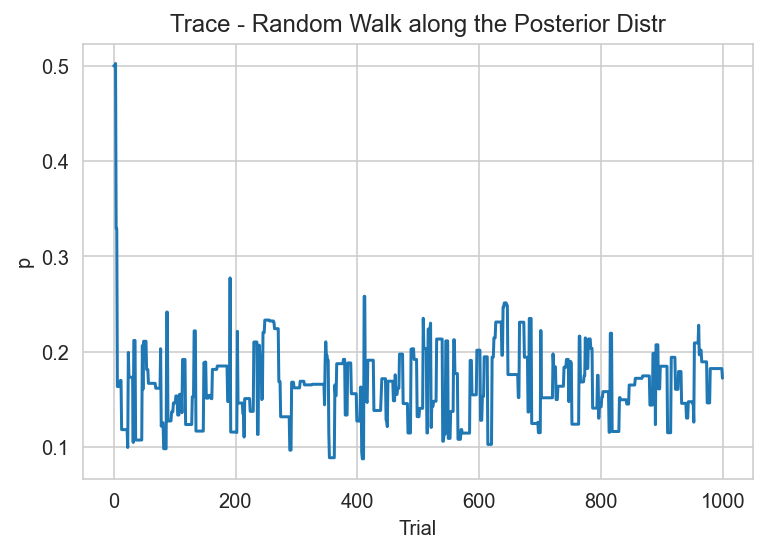

In [32]:
# View the trace

plt.plot(np.arange(len(posterior[:1000])), posterior[:1000]);            # [:] to make it easy to view a subset
plt.title('Trace - Random Walk along the Posterior Distr');
plt.xlabel('Trial');
plt.ylabel('p');

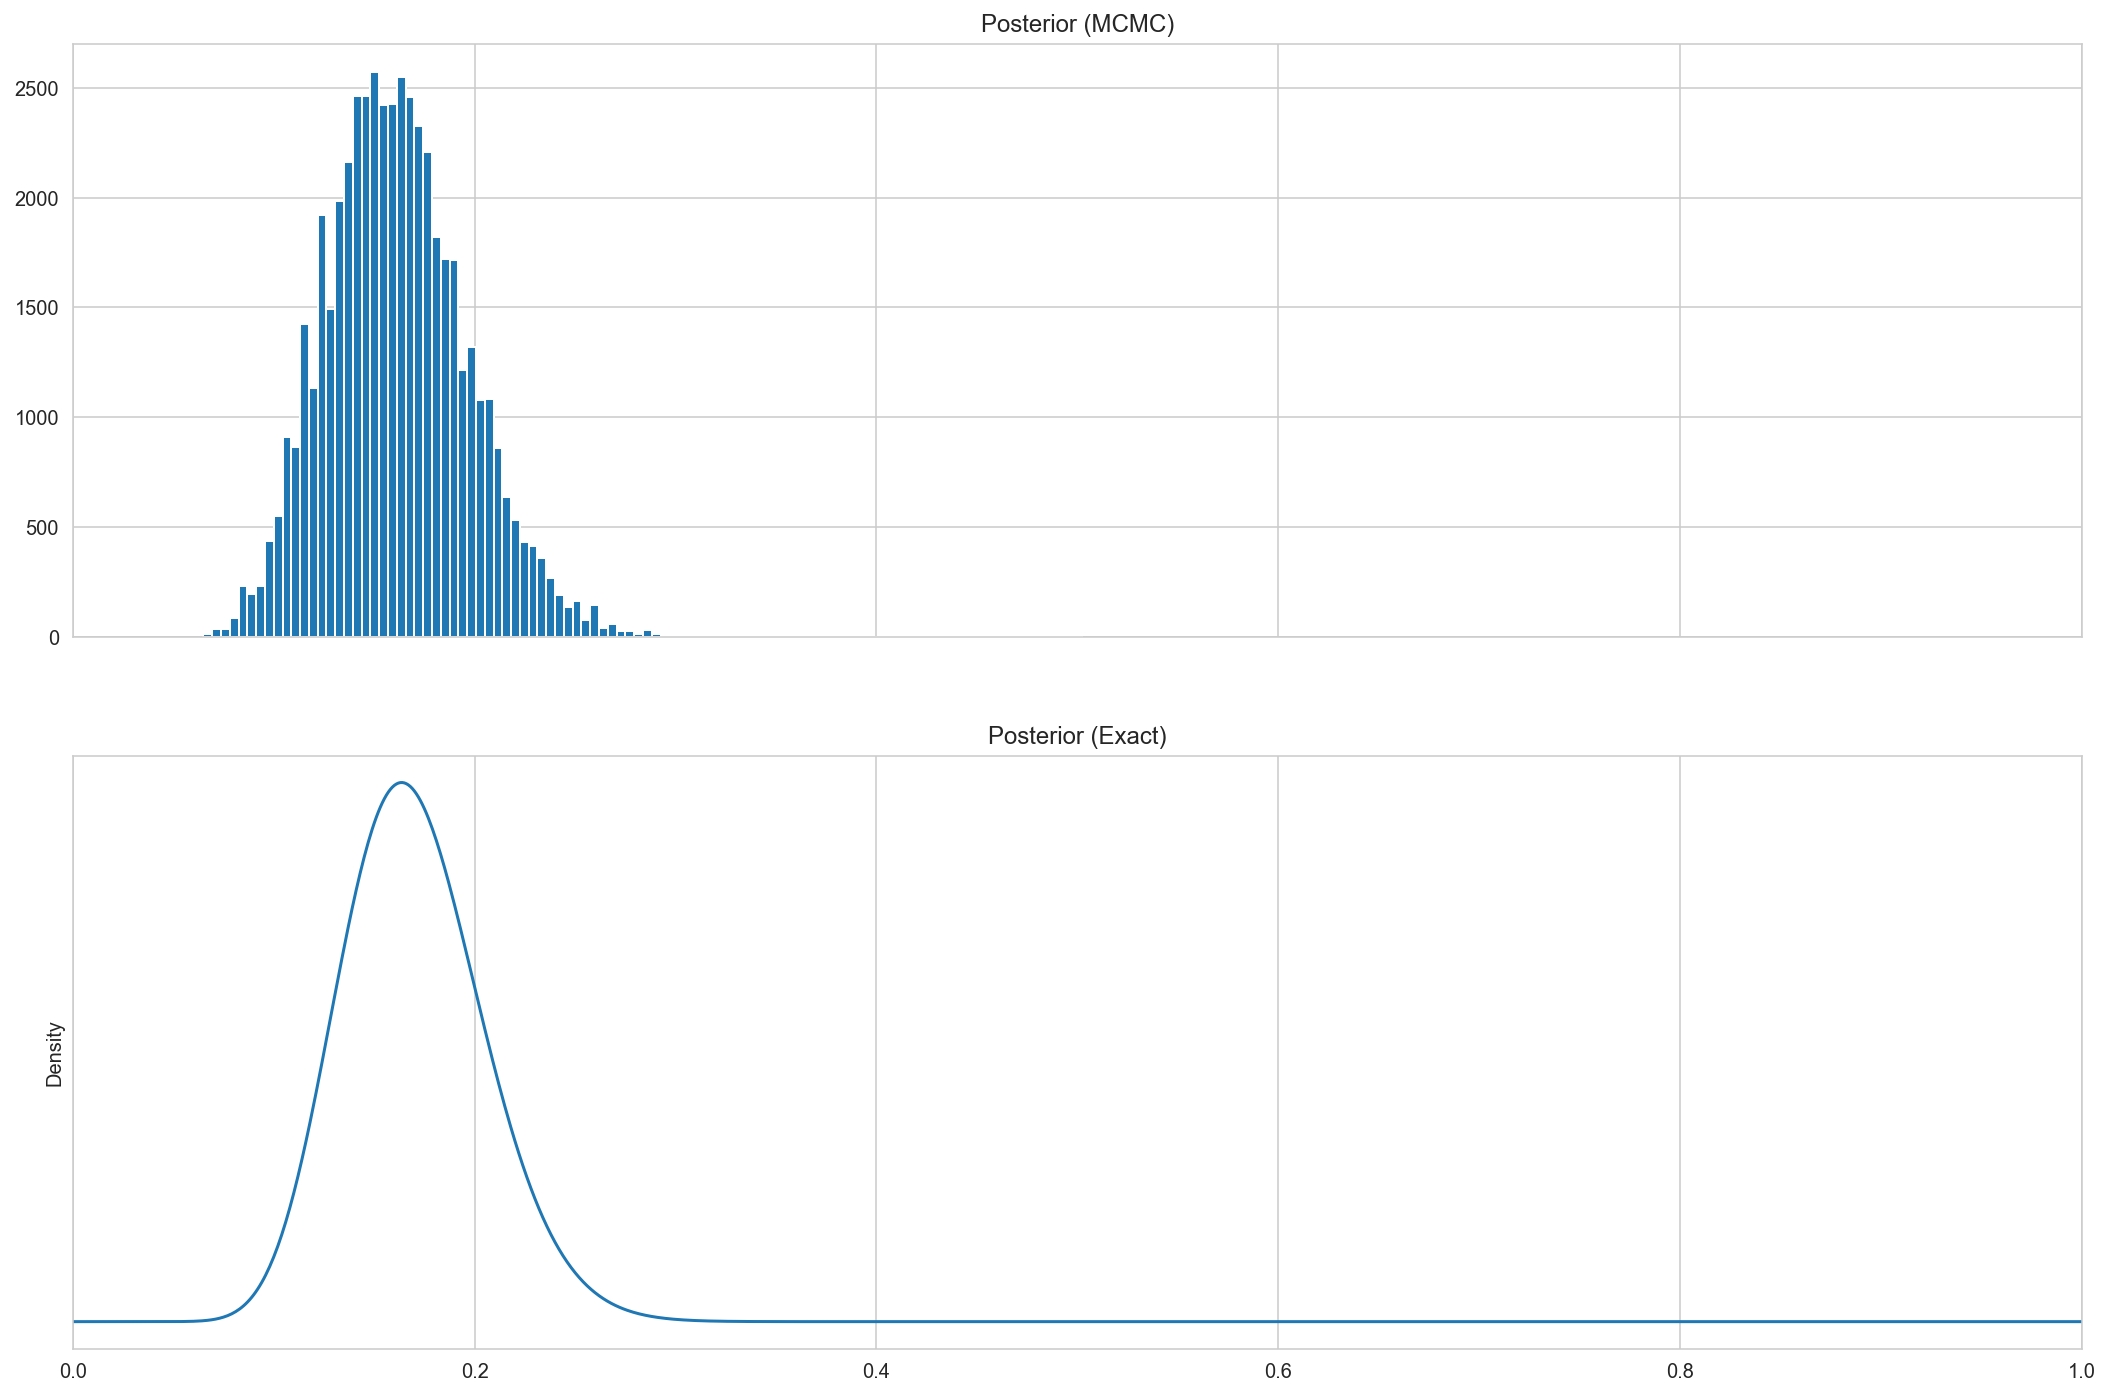

In [33]:
fig, (ax_mcmc, ax_posterior) = plt.subplots(2,1, figsize=(18,12), sharex=True)

ax_mcmc.hist(posterior, bins=100);
ax_mcmc.set_title('Posterior (MCMC)')

# Plot posterior
ax_posterior.plot(percentages_for_plotting_x_axes, posterior_distr.pdf(percentages_for_plotting_x_axes))
ax_posterior.set_xlim([0, 1]);
ax_posterior.set_ylabel('Density');
ax_posterior.set_yticks([]);
ax_posterior.set_title('Posterior (Exact)');

<a id="match"></a>
## Match a Beta Distribution Using Moment Matching

We can specify a beta distribution via $\alpha, \beta$ -or- by specifying a mean and variance -- the first and second moments.

To convert from mean and variance, we can solve for $\alpha$ and $\beta$ by solving simultaneously:

$$
\mu = \frac{\alpha}{\alpha + \beta}
$$

$$
\sigma^2 = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}
$$

Let's try fitting a beta distribution to our sample data by using its mean and variance.

In [34]:
# Let's use moment matching to find a beta distribution
mean = posterior.mean()
var = posterior.var()

# These are found by rearranging the mean and variance of the Beta distribution
alpha_mcmc = -(mean * (var + mean*mean - mean) / var)
beta_mcmc = (var + mean*mean - mean)*(mean - 1) / var
          
print(f'MCMC Beta distr: alpha={alpha_mcmc}, beta={beta_mcmc}')
print(f'Actual Beta distr: alpha={alpha_posterior}, beta={beta_posterior}')

#############

MCMC Beta distr: alpha=17.776638290171537, beta=92.47785654395418
Actual Beta distr: alpha=19, beta=93


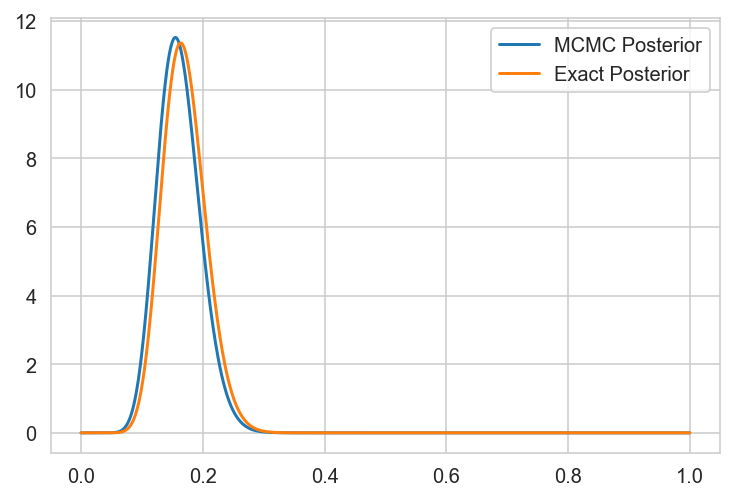

In [35]:
posterior_mcmc_distn = beta(alpha_mcmc, beta_mcmc)

plt.plot(percentages_for_plotting_x_axes, posterior_mcmc_distn.pdf(percentages_for_plotting_x_axes), label='MCMC Posterior')
plt.plot(percentages_for_plotting_x_axes, posterior_distr.pdf(percentages_for_plotting_x_axes), label='Exact Posterior');

plt.legend();

<a id="#ci"></a>
## Confidence Intervals

To explain your results, you would report a **Bayesian credible interval** for the simulated value, i.e. the 95% confidence interval.

Here, we'll examine the most popular -- the **equal-tailed interval method**.

We will report the mean $p$ and the 95% confidence interval. Luckily, we can draw a histogram already, so finding this interval will be easy.

<a id="other"></a>
## Other Considerations

- More trials means a better estimate of the posterior distribution.
    - Many simulations use > 10000 trials.
- Target an acceptance rate of 20-50%. If it is too high or low, we are not stuck nearby certain values and may not be exploring the full distribution.
    - Adjust the tuning parameter $\beta$ -- which adjusts how new values are proposed. Increase $\beta$ if acceptance is too high.
- Note that the first values are not good, since we move from 0.5 to where the real distribution lies (the "burn in" period).
    - Consider removing some of the first samples when they are outside the typical range of the posterior distribution.

**Challenge.** Can you apply some of these to the above to get better estimates? 